# Sceptic Advanced Evaluation and Visualization

This notebook demonstrates how to use Sceptic's utility modules for comprehensive evaluation and publication-quality visualizations.

## New Features

We'll explore:
1. **Evaluation utilities**: Statistical metrics (correlations, MAE/MSE, balanced accuracy)
2. **Plotting utilities**: Publication-quality confusion matrices and violin plots
3. **Comprehensive reporting**: All-in-one evaluation function

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sceptic import run_sceptic_and_evaluate

# Import new utility modules
from sceptic import evaluation, plotting

# Set publication style for all plots
plotting.set_publication_style()

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data and Run Sceptic

We'll use the scGEM dataset with encoded labels for internal calculations.

In [2]:
# Load example data
data_concat = np.loadtxt("../example_data/scGEM/expression.txt")
y = np.loadtxt("../example_data/scGEM/expression_type.txt")

# Encode labels for Sceptic
lab = preprocessing.LabelEncoder()
label = lab.fit_transform(y)

# Map encoded labels to actual biological time points (hours) for visualization
time_dictionary = {0: 0, 1: 8, 2: 16, 3: 24, 4: 30}
label_list = pd.Series(np.unique(label)).map(time_dictionary).to_numpy()

print(f"Data shape: {data_concat.shape}")
print(f"Encoded labels: {np.unique(label)}")
print(f"Actual time points (hours): {label_list}")

Data shape: (177, 34)
Encoded labels: [0 1 2 3 4]
Actual time points (hours): [ 0  8 16 24 30]


In [3]:
# Run Sceptic with encoded labels and actual time mapping
parameters = {
    "max_depth": [3, 5],
    "learning_rate": [0.1, 0.3],
    "n_estimators": [100],
    "subsample": [0.8]
}

print("Running Sceptic...")
cm, label_predicted, pseudotime, sceptic_prob = run_sceptic_and_evaluate(
    data=data_concat,
    labels=label,  # Encoded labels
    label_list=label_list,  # Actual time points for output
    parameters=parameters,
    method="xgboost"
)

print("Sceptic analysis complete!")
print(f"Pseudotime range: {pseudotime.min():.1f} - {pseudotime.max():.1f} hours")

Running Sceptic...
Sceptic analysis complete!
Pseudotime range: 0.2 - 29.8 hours


## 3. Comprehensive Evaluation

Use the `evaluate_sceptic_results` function to get all metrics at once.

In [4]:
# Run comprehensive evaluation
# Use encoded labels for classification metrics, actual time for correlations
actual_time = pd.Series(label).map(time_dictionary).to_numpy()

results = evaluation.evaluate_sceptic_results(
    confusion_matrix=cm,
    y_true=label,  # Encoded labels for classification
    y_pred=label_predicted,  # Already encoded
    pseudotime=pseudotime,
    true_time=actual_time,  # Actual hours for correlations
    include_regression=True,  # Include MAE/MSE
    verbose=True
)

SCEPTIC EVALUATION RESULTS

Confusion Matrix Accuracy: 0.9322
Accuracy: 0.9322
Balanced Accuracy: 0.9313

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       0.90      0.95      0.93        40
           2       0.93      0.88      0.90        32
           3       0.91      0.86      0.89        36
           4       0.94      0.97      0.96        34

    accuracy                           0.93       177
   macro avg       0.93      0.93      0.93       177
weighted avg       0.93      0.93      0.93       177


Correlation Metrics:
  Spearman  r = 0.9527 (p = 1.78e-92)
  Pearson   r = 0.9647 (p = 2.60e-103)
  Kendall   τ = 0.8526 (p = 1.04e-53)

Regression Metrics:
  MAE  = 1.1697
  MSE  = 8.0399
  RMSE = 2.8355


## 4. Individual Metric Functions

You can also compute individual metrics separately.

### 4.1 Classification Metrics

In [5]:
# Compute classification metrics (uses encoded labels)
class_metrics = evaluation.compute_classification_metrics(
    y_true=label,
    y_pred=label_predicted
)

print(f"Accuracy: {class_metrics['accuracy']:.4f}")
print(f"Balanced Accuracy: {class_metrics['balanced_accuracy']:.4f}")
print("\nPer-class metrics:")
print(class_metrics['classification_report'])

Accuracy: 0.9322
Balanced Accuracy: 0.9313

Per-class metrics:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       0.90      0.95      0.93        40
           2       0.93      0.88      0.90        32
           3       0.91      0.86      0.89        36
           4       0.94      0.97      0.96        34

    accuracy                           0.93       177
   macro avg       0.93      0.93      0.93       177
weighted avg       0.93      0.93      0.93       177



### 4.2 Correlation Metrics

These use **actual biological time** (hours), not encoded labels!

In [6]:
# Compute correlations between pseudotime and true time (in hours)
corr_metrics = evaluation.compute_correlation_metrics(
    pseudotime=pseudotime,
    true_time=actual_time  # Actual hours!
)

print("Correlation Metrics (using actual hours):")
spear_r, spear_p = corr_metrics['spearman']
pear_r, pear_p = corr_metrics['pearson']
kend_tau, kend_p = corr_metrics['kendall']

print(f"  Spearman  r = {spear_r:.4f} (p = {spear_p:.2e})")
print(f"  Pearson   r = {pear_r:.4f} (p = {pear_p:.2e})")
print(f"  Kendall   τ = {kend_tau:.4f} (p = {kend_p:.2e})")

Correlation Metrics (using actual hours):
  Spearman  r = 0.9527 (p = 1.78e-92)
  Pearson   r = 0.9647 (p = 2.60e-103)
  Kendall   τ = 0.8526 (p = 1.04e-53)


### 4.3 Regression Metrics

In [7]:
# Compute regression metrics (MAE, MSE, RMSE) in hours
reg_metrics = evaluation.compute_regression_metrics(
    pseudotime=pseudotime,
    true_time=actual_time  # Actual hours!
)

print("Regression Metrics (in hours):")
print(f"  MAE  = {reg_metrics['mae']:.4f} hours")
print(f"  MSE  = {reg_metrics['mse']:.4f}")
print(f"  RMSE = {reg_metrics['rmse']:.4f} hours")

Regression Metrics (in hours):
  MAE  = 1.1697 hours
  MSE  = 8.0399
  RMSE = 2.8355 hours


## 5. Publication-Quality Visualizations

Create publication-ready figures using the plotting utilities.

**Important:** All plots now show actual biological time in hours!

### 5.1 Confusion Matrix Heatmap

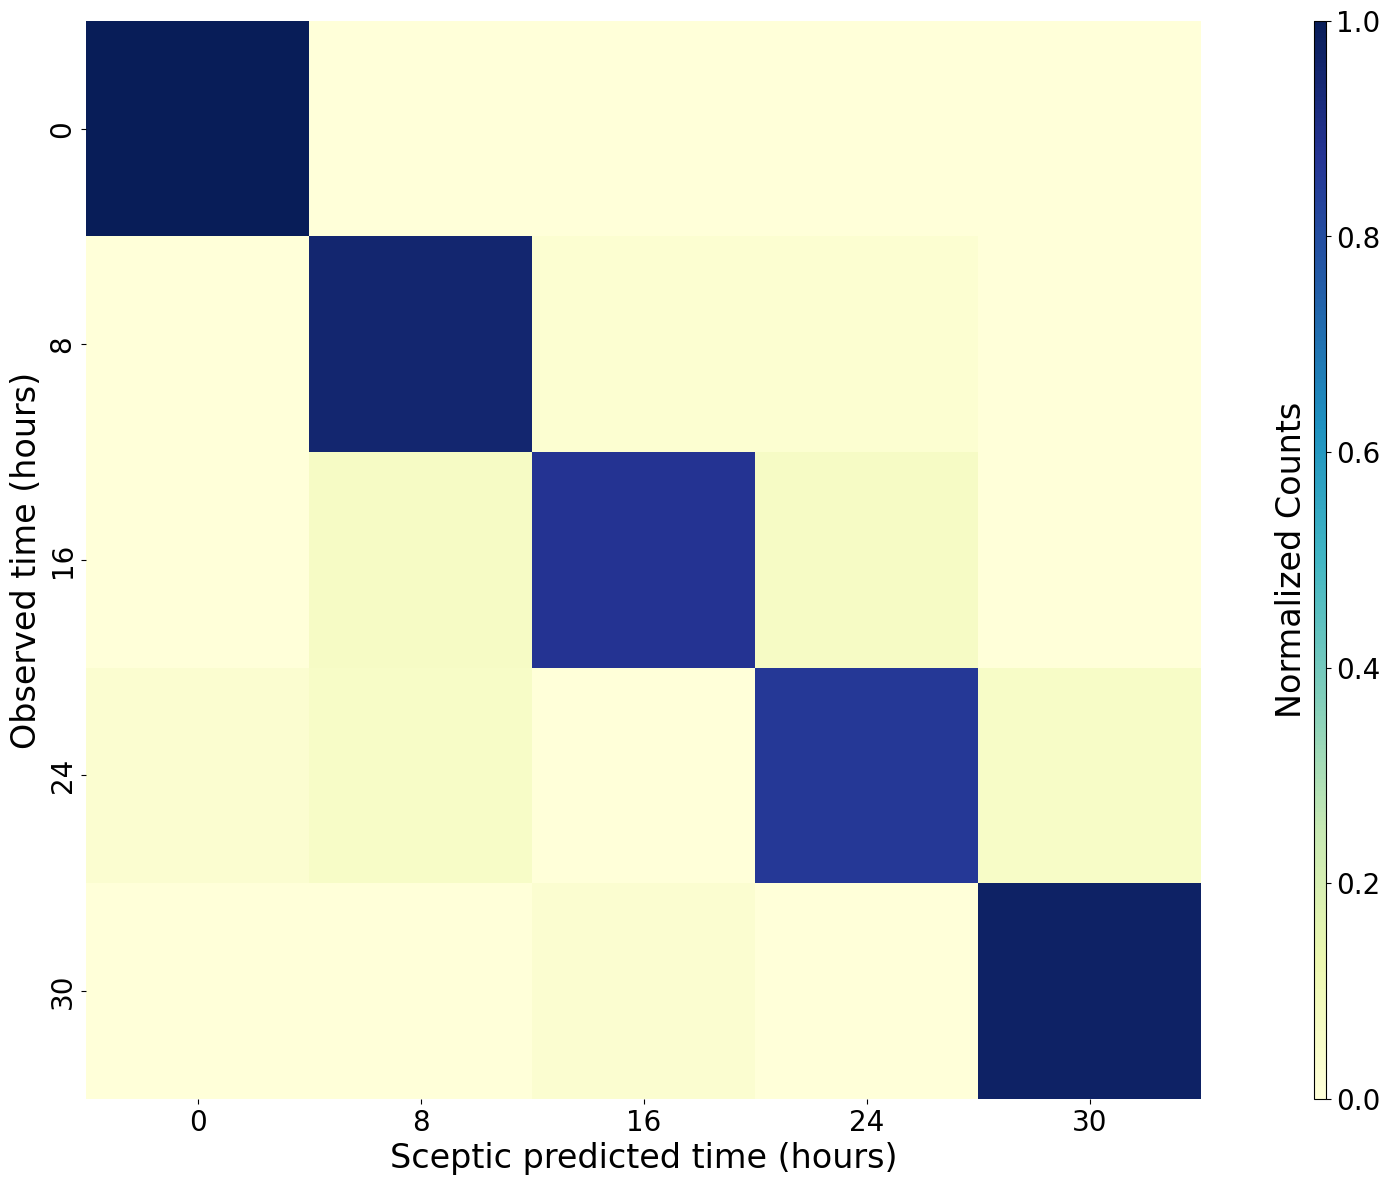

Confusion matrix saved!


In [8]:
import matplotlib.pyplot as plt

# Create publication-quality confusion matrix with actual time labels
fig = plotting.plot_confusion_matrix(
    confusion_matrix=cm,
    label_list=label_list,  # Actual hours for axis labels
    output_path="confusion_matrix.png",  # Set to None to not save
    normalize=True,
    cmap="YlGnBu",
    figsize=(16, 14),
    xlabel="Sceptic predicted time (hours)",
    ylabel="Observed time (hours)",
    dpi=300
)

plt.show()
print("Confusion matrix saved!")

### 5.2 Violin Plot: Pseudotime by True Time

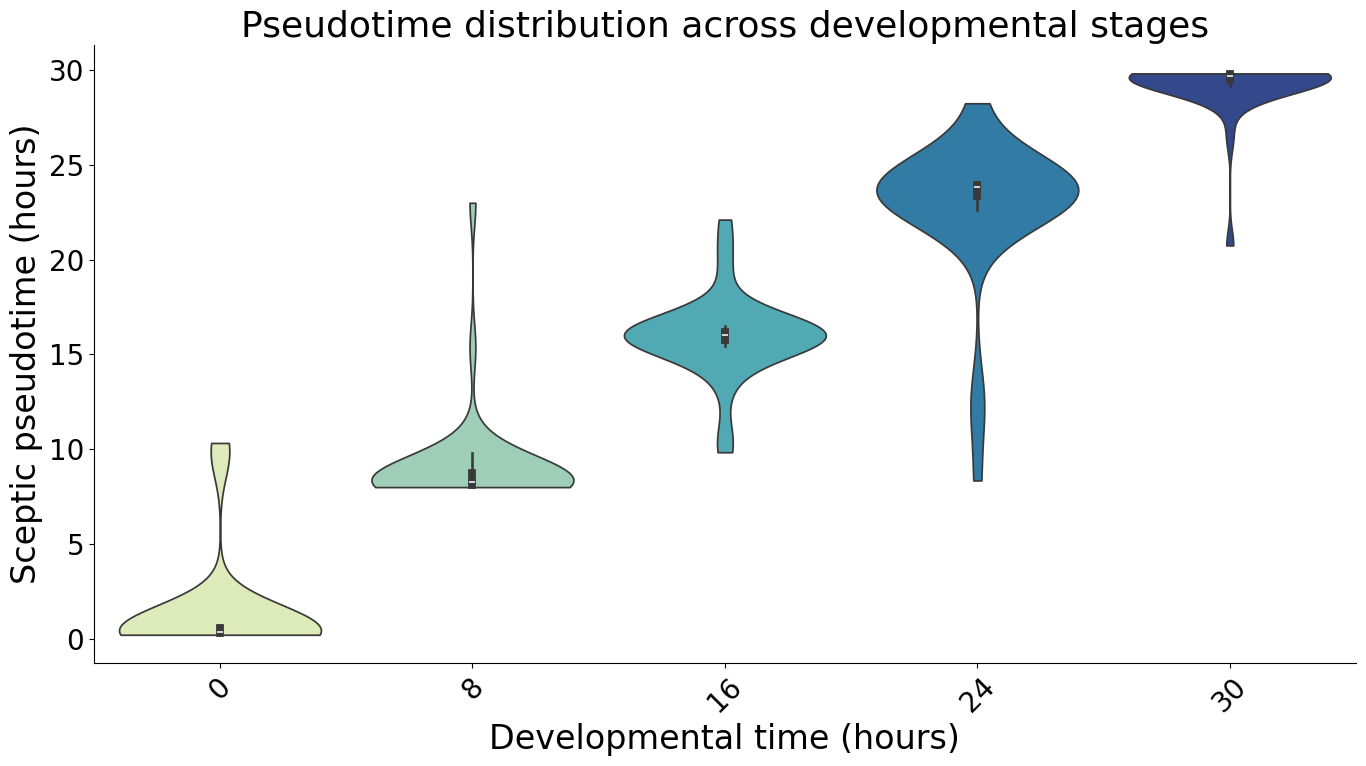

Violin plot saved!


In [9]:
# Create violin plot showing pseudotime distribution
fig = plotting.plot_pseudotime_violin(
    pseudotime=pseudotime,
    true_labels=actual_time,  # Actual hours!
    output_path="violin_plot.png",  # Set to None to not save
    figsize=(14, 8),
    palette='YlGnBu',
    xlabel="Developmental time (hours)",
    ylabel="Sceptic pseudotime (hours)",
    title="Pseudotime distribution across developmental stages",
    dpi=300
)

plt.show()
print("Violin plot saved!")

### 5.3 Stratified Analysis by Groups

If you have group information (e.g., cell types), you can create separate plots for each group.

In [10]:
# Example: Create mock cell type labels for demonstration
# In practice, you would have real cell type labels from your data
np.random.seed(42)
mock_cell_types = np.random.choice(
    ['Type A', 'Type B', 'Type C'],
    size=len(pseudotime)
)

# Create separate violin plots for each cell type
plotting.plot_pseudotime_by_group(
    pseudotime=pseudotime,
    true_labels=actual_time,  # Actual hours!
    group_labels=mock_cell_types,
    output_dir="violin_by_cell_type",
    top_k=3,  # Plot top 3 most frequent groups
    figsize=(14, 8),
    palette='YlGnBu',
    xlabel="Developmental time (hours)",
    ylabel="Sceptic pseudotime (hours)",
    title_template="Pseudotime distribution\nCell type: {group}",
    dpi=300
)

print("Stratified plots saved in violin_by_cell_type/ directory!")

Saved 3 violin plots to: violin_by_cell_type
Stratified plots saved in violin_by_cell_type/ directory!


## 6. Customizing Plot Appearance

You can customize the publication style settings.

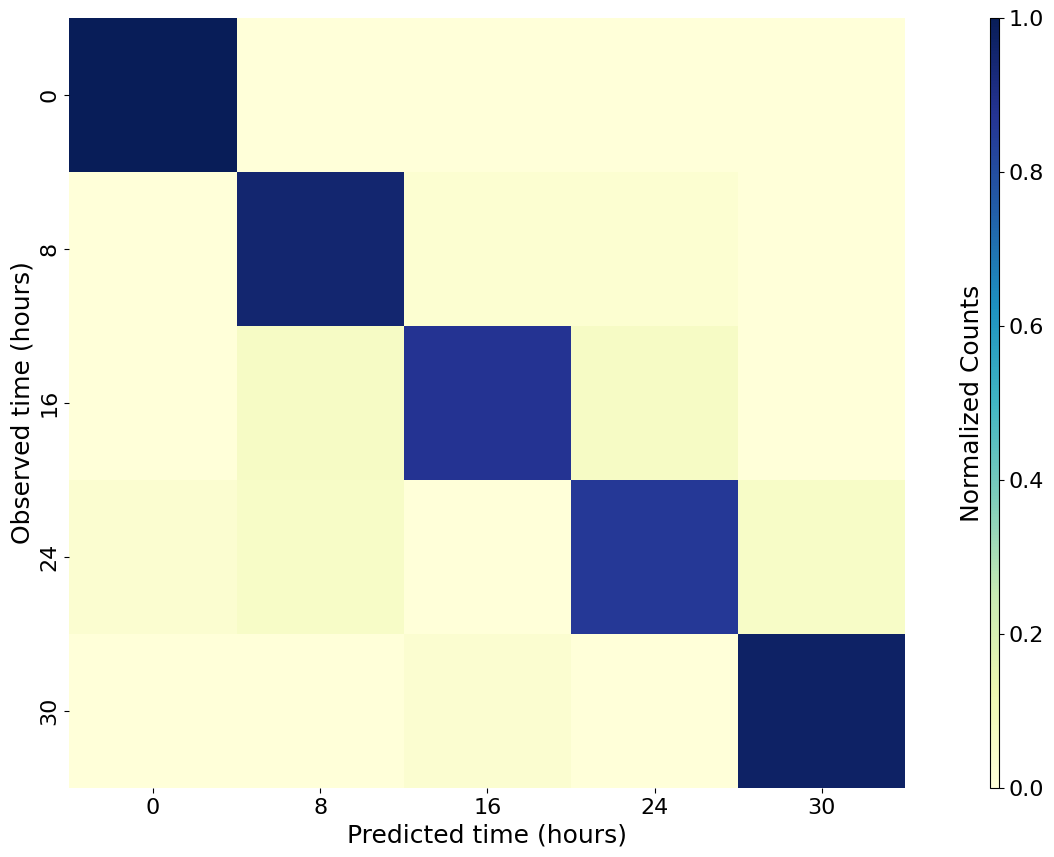

In [16]:
# Set custom font sizes
plotting.set_publication_style(
    small_size=16,
    medium_size=18,
    bigger_size=22
)

# Create another confusion matrix with new style
fig = plotting.plot_confusion_matrix(
    confusion_matrix=cm,
    label_list=label_list,  # Actual hours!
    normalize=True,
    figsize=(12, 10),
    annot_fontsize=14,
    tick_fontsize=16,
    label_fontsize=18,
    xlabel="Predicted time (hours)",
    ylabel="Observed time (hours)"
)

plt.show()

## 7. Creating a Comprehensive Results Table

Combine all metrics into a summary table.

In [17]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Balanced Accuracy',
        'Spearman r',
        'Pearson r',
        'Kendall τ',
        'MAE (hours)',
        'RMSE (hours)'
    ],
    'Value': [
        f"{results['accuracy']:.4f}",
        f"{results['balanced_accuracy']:.4f}",
        f"{results['spearman'][0]:.4f}",
        f"{results['pearson'][0]:.4f}",
        f"{results['kendall'][0]:.4f}",
        f"{results['mae']:.4f}",
        f"{results['rmse']:.4f}"
    ],
    'p-value': [
        'N/A',
        'N/A',
        f"{results['spearman'][1]:.2e}",
        f"{results['pearson'][1]:.2e}",
        f"{results['kendall'][1]:.2e}",
        'N/A',
        'N/A'
    ]
})

print("\nSummary of Sceptic Performance:")
print(summary.to_string(index=False))

# Optionally save to CSV
# summary.to_csv('sceptic_results_summary.csv', index=False)


Summary of Sceptic Performance:
           Metric  Value   p-value
         Accuracy 0.9322       N/A
Balanced Accuracy 0.9313       N/A
       Spearman r 0.9527  1.78e-92
        Pearson r 0.9647 2.60e-103
        Kendall τ 0.8526  1.04e-53
      MAE (hours) 1.1697       N/A
     RMSE (hours) 2.8355       N/A


## 8. Best Practices for Reporting

When reporting Sceptic results in publications:

1. **Always report**:
   - Accuracy or balanced accuracy (if classes are imbalanced)
   - At least one correlation metric (Spearman recommended for monotonic relationships)
   - Confusion matrix visualization
   - **Use actual biological time units** (hours, days, stages) not encoded labels!

2. **Consider reporting**:
   - Per-class precision/recall (from classification report)
   - Violin plots showing pseudotime distributions
   - MAE/RMSE in biological time units (e.g., "MAE = 2.3 hours")

3. **For stratified analysis**:
   - Report metrics separately for important subgroups (e.g., cell types)
   - Include sample sizes for each group

4. **Reproducibility**:
   - Report parameter grids used
   - Mention cross-validation strategy (external/internal folds)
   - Include random seeds if applicable
   - **Document time label mappings** (e.g., "0h, 8h, 16h, 24h, 30h")

## Summary

In this notebook, we demonstrated:
1. **Comprehensive evaluation** with `evaluate_sceptic_results()`
2. **Individual metric functions** for flexibility
3. **Publication-quality visualizations** with meaningful time labels in hours
4. **Stratified analysis** by groups
5. **Best practices** for reporting results

**Key Design:**
- Internal calculations use encoded labels (0,1,2,3,4) for robustness
- Visualizations and reporting use actual biological time (0,8,16,24,30 hours) for interpretability
- Correlations and regression metrics use actual time units

These utilities make it easier to thoroughly evaluate and present Sceptic results!